In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from pandas import Series, DataFrame, read_csv
from scipy.integrate import solve_ivp
from labellines import labelLine, labelLines
from dataclasses import dataclass

In [2]:
%matplotlib notebook

# mpl.rc("figure", dpi=300)
# mpl.rc("savefig", dpi=300)

In [3]:
g = 9.8 # m / s2
R = 8.314 # J / mol K

In [4]:
substance_data = read_csv("res/substance_data.csv").set_index("Species")

def _as_substance_series(a, **kwargs):
    return Series(a, index=substance_data.index, **kwargs)

substance_data

,Cp(J/molK),Hf(J/mol),MW(g/mol),p(kg/m3)
Species,,,,
GLY,221.18,-669600.0,92.0938,1260.00
AAC,159.80,-483520.0,60.0520,1050.00
W,75.38,-285830.0,18.0153,997.77
TAC,389.00,-1330800.0,218.2039,1160.00
DAC,340.98,-1120700.0,176.1672,1170.00
MAC,291.36,-903530.0,134.1305,1200.00


In [5]:
def _convert(df, src, dst, factor):
    _df = df
    if src in df.columns:
        _df[dst] = _df[src] * factor
    return _df

kinetic_parameters = read_csv("res/kinetic_parameters_bonet.csv").set_index("i")
kineitc_parameters = _convert(kinetic_parameters, "Ea(cal/mol)", "Ea(J/mol)", 4.184)
kinetic_parameters

,A(L/mols),Ea(J/mol)
i,,
1,6.9,31000.0
2,190.0,33000.0
3,6.8,31000.0
4,220.0,38000.0
5,2.4,34000.0
6,200.0,43000.0


In [6]:
reaction_data = DataFrame(
    [[kinetic_parameters["A(L/mols)"][1], kinetic_parameters["Ea(J/mol)"][1], 
      kinetic_parameters["A(L/mols)"][2], kinetic_parameters["Ea(J/mol)"][2]],
     [kinetic_parameters["A(L/mols)"][3], kinetic_parameters["Ea(J/mol)"][3], 
      kinetic_parameters["A(L/mols)"][4], kinetic_parameters["Ea(J/mol)"][4]],
     [kinetic_parameters["A(L/mols)"][5], kinetic_parameters["Ea(J/mol)"][5], 
      kinetic_parameters["A(L/mols)"][6], kinetic_parameters["Ea(J/mol)"][6]]],
    index=[1, 2, 3],
    columns=["A(L/mols)", "Ea(J/mol)", "A-1(L/mols)", "Ea-1(J/mol)"]
)

def _hstd(r, p):
    return np.sum([v * H for v, H in p]) - np.sum([v * H for v, H in r])

reaction_data.loc[1, "Hstd(J/mol)"] = _hstd(
    [(1, substance_data["Hf(J/mol)"]["GLY"]), (1, substance_data["Hf(J/mol)"]["AAC"])],
    [(1, substance_data["Hf(J/mol)"]["MAC"]), (1, substance_data["Hf(J/mol)"]["W"])]
)

reaction_data.loc[2, "Hstd(J/mol)"] = _hstd(
    [(1, substance_data["Hf(J/mol)"]["MAC"]), (1, substance_data["Hf(J/mol)"]["AAC"])],
    [(1, substance_data["Hf(J/mol)"]["DAC"]), (1, substance_data["Hf(J/mol)"]["W"])]
)

reaction_data.loc[3, "Hstd(J/mol)"] = _hstd(
    [(1, substance_data["Hf(J/mol)"]["DAC"]), (1, substance_data["Hf(J/mol)"]["AAC"])],
    [(1, substance_data["Hf(J/mol)"]["TAC"]), (1, substance_data["Hf(J/mol)"]["W"])]
)

def _as_reaction_series(a, **kwargs):
    return Series(a, index=reaction_data.index, **kwargs)

reaction_data

,A(L/mols),Ea(J/mol),A-1(L/mols),Ea-1(J/mol),Hstd(J/mol)
1,6.9,31000.0,190.0,33000.0,-36240.0
2,6.8,31000.0,220.0,38000.0,-19480.0
3,2.4,34000.0,200.0,43000.0,-12410.0


In [7]:
reaction_rate_table = _as_reaction_series(None, dtype="object")

def _arrhenius(A, Ea, T):
    return A * np.exp(-Ea / (R * T))


def _create_reaction_rate_function(j, l):
    def _f(C, T):
        s = _as_substance_series(C)
        
        A = reaction_data.loc[j, "A(L/mols)"]
        Ea = reaction_data.loc[j, "Ea(J/mol)"]
        k = _arrhenius(A, Ea, T)
        
        Ainv = reaction_data.loc[j, "A-1(L/mols)"]
        Eainv = reaction_data.loc[j, "Ea-1(J/mol)"]
        kinv = _arrhenius(Ainv, Eainv, T)
        
        a, b, c, d = (s[l[i]] for i in range(0, 4))
        
        return -k * a * b + kinv * c * d
    return _f
    

reaction_rate_table[1] = _create_reaction_rate_function(j=1, l=["GLY", "AAC", "MAC", "W"])
reaction_rate_table[2] = _create_reaction_rate_function(j=2, l=["MAC", "AAC", "DAC", "W"])
reaction_rate_table[3] = _create_reaction_rate_function(j=3, l=["DAC", "AAC", "TAC", "W"])

reaction_rate_table

1    <function _create_reaction_rate_function.<loca...
2    <function _create_reaction_rate_function.<loca...
3    <function _create_reaction_rate_function.<loca...
dtype: object

In [8]:
net_reaction_rate_table = _as_substance_series(None, dtype="object")

def _create_net_reaction_rate_function(f):
    def _f(C, T, r=reaction_rate_table):
        return f(C, T, r)
    return _f

net_reaction_rate_table["GLY"] = _create_net_reaction_rate_function(
    lambda C, T, r: r[1](C, T) 
)

net_reaction_rate_table["AAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: r[1](C, T) + r[2](C, T) + r[3](C, T)
)

net_reaction_rate_table["W"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[1](C, T) - r[2](C, T) - r[3](C, T)
)

net_reaction_rate_table["TAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[3](C, T)
)

net_reaction_rate_table["DAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[2](C, T) + r[3](C, T)
)

net_reaction_rate_table["MAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[1](C, T) + r[2](C, T)
)

net_reaction_rate_table

Species
GLY    <function _create_net_reaction_rate_function.<...
AAC    <function _create_net_reaction_rate_function.<...
W      <function _create_net_reaction_rate_function.<...
TAC    <function _create_net_reaction_rate_function.<...
DAC    <function _create_net_reaction_rate_function.<...
MAC    <function _create_net_reaction_rate_function.<...
dtype: object

In [9]:
def evaluate_reaction_rates(C, T):
    # C: (L/mol), T: (K), return: (mol/Ls)
     return _as_reaction_series([r(C, T) for r in reaction_rate_table])


def evaluate_net_reaction_rates(C, T):
    # C: (L/mol), T: (K), return: (mol/Ls)
    return _as_substance_series([r(C, T) for r in net_reaction_rate_table])


def evaluate_temperature_rate(v, F, T, Ta, D, U):
    # v: (L/s), F: (mol/s), T: (K), Ta: (K), D: (m),  U: (W/m2K), return: (K/dm)
    _U = U / 100 # W/dm2K
    _D = D * 10 # dm
    At = np.pi * _D * _D / 4 # dm2
    r = evaluate_reaction_rates(F / v, T)
    
    # this works because the acetic acid has v=-1 in all reactions
    _1 = _U * 4 / _D * (Ta - T)
    _2 = np.sum([-rij * -Hrxnij for rij, Hrxnij in zip(r, reaction_data["Hstd(J/mol)"])])
    _3 = np.sum([Fi * Cpi for Fi, Cpi in zip(F, substance_data["Cp(J/molK)"])])
    
    return (_1 + _2) / _3 * At


def _as_objective_function_series(parameters):
    index = substance_data.index.union(["T(K)"], sort=False)
    return Series(parameters, index=index)


def _unpack_objective_function_vector(vector):
    s = _as_objective_function_series(vector)
    return s.loc(axis=0)[substance_data.index], s["T(K)"]


def _create_objective_function(v0, F0, Ta, D, U):
    def objective_function(L, vector):
        F, T = _unpack_objective_function_vector(vector)
        _r = evaluate_net_reaction_rates(F / v0, T)
        _T = evaluate_temperature_rate(v0, F, T, Ta, D, U)
        return np.concatenate((_r, [_T]))
    return objective_function


def _estimate_density(F):
    return np.average(substance_data["p(kg/m3)"])


def _bernoulli_pressure_drop(F, L):
    p = _estimate_density(F)
    return p * g * L * 9.86923e-6


def _estimate_volumetric_flow(F):
    s = _as_substance_series(F) # mol / s
    w = substance_data["MW(g/mol)"] * s / 1000 # kg / mol
    return np.sum(w / substance_data["p(kg/m3)"]) * 1000 # L / s


def solve(F0, T0, P0, Ta, D, U, L, **kwargs):
    v0 = _estimate_volumetric_flow(F0) # L / s
    
    # create the objective function
    _f = _create_objective_function(v0, F0, Ta, D, U)
    
    _L = L * 10 # dm
    
    # solve with RK45
    r = solve_ivp(_f, [0, _L], np.concatenate((F0, [T0])), **kwargs)
    
    index = r.t / 10
    
    # create the molar flows dataframe
    F = DataFrame(r.y[:-1].transpose(), index=index, columns=substance_data.index.to_numpy())
    
    # create a temperature series
    T = Series(r.y[-1], index=index, name="T(K)")
    
    pressure_drop = np.vectorize(lambda L: _bernoulli_pressure_drop(F0, L))
    
    # create a pressure series
    P = Series(P0 - pressure_drop(index), index=index, name="L(m)")
    
    # create a reaction rate series
    r = [evaluate_net_reaction_rates(f, t).to_numpy() for f, t in zip(F.to_numpy(), T.to_numpy())]
    r =  DataFrame(r, index=index, columns=substance_data.index.to_numpy())
    
    return F, T, P, r

In [10]:
F400, T400, P400, r400 = solve(
    F0=[0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0=400, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=5, # W / m2 C
    L=15, # m
    max_step=1
)

In [11]:
F420, T420, P420, r420 = solve(
    F0=[0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=5, # W / m2 C
    L=15, # m
    max_step=1
)

In [12]:
F380, T380, P380, r380 = solve(
    F0=[0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0=380, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=5, # W / m2 C
    L=15, # m
    max_step=1
)

In [13]:
F440, T440, P440, r440 = solve(
    F0=[0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0=440, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=5, # W / m2 C
    L=15, # m
    max_step=1
)

In [14]:
T380

0.000000     380.000000
0.007871     380.002293
0.086580     380.024744
0.186580     380.051892
0.286580     380.077325
                ...    
14.686580    379.049259
14.786580    379.037974
14.886580    379.026685
14.986580    379.015393
15.000000    379.013878
Name: T(K), Length: 153, dtype: float64

In [15]:
T400

0.000000     400.000000
0.007135     400.003718
0.078488     400.039827
0.178488     400.086675
0.278488     400.128573
                ...    
14.678488    398.635670
14.778488    398.621306
14.878488    398.606939
14.978488    398.592569
15.000000    398.589477
Name: T(K), Length: 153, dtype: float64

In [16]:
T420

0.000000     420.000000
0.006529     420.005644
0.071820     420.059824
0.171820     420.133378
0.271820     420.194284
                ...    
14.671820    418.202010
14.771820    418.184578
14.871820    418.167146
14.971820    418.149715
15.000000    418.144803
Name: T(K), Length: 153, dtype: float64

In [17]:
T440

0.000000     440.000000
0.005170     440.006988
0.056872     440.073622
0.156872     440.182207
0.256872     440.262559
                ...    
14.656872    437.762287
14.756872    437.741948
14.856872    437.721613
14.956872    437.701280
15.000000    437.692512
Name: T(K), Length: 153, dtype: float64

In [18]:
P380

0.000000     3.000000
0.007871     2.999132
0.086580     2.990457
0.186580     2.979435
0.286580     2.968412
               ...   
14.686580    1.381200
14.786580    1.370177
14.886580    1.359155
14.986580    1.348133
15.000000    1.346654
Name: L(m), Length: 153, dtype: float64

In [19]:
P400

0.000000     3.000000
0.007135     2.999214
0.078488     2.991349
0.178488     2.980327
0.278488     2.969304
               ...   
14.678488    1.382092
14.778488    1.371069
14.878488    1.360047
14.978488    1.349025
15.000000    1.346654
Name: L(m), Length: 153, dtype: float64

In [20]:
P420

0.000000     3.000000
0.006529     2.999280
0.071820     2.992084
0.171820     2.981061
0.271820     2.970039
               ...   
14.671820    1.382827
14.771820    1.371804
14.871820    1.360782
14.971820    1.349760
15.000000    1.346654
Name: L(m), Length: 153, dtype: float64

In [21]:
P440

0.000000     3.000000
0.005170     2.999430
0.056872     2.993731
0.156872     2.982709
0.256872     2.971687
               ...   
14.656872    1.384474
14.756872    1.373452
14.856872    1.362430
14.956872    1.351407
15.000000    1.346654
Name: L(m), Length: 153, dtype: float64

<IPython.core.display.Javascript object>


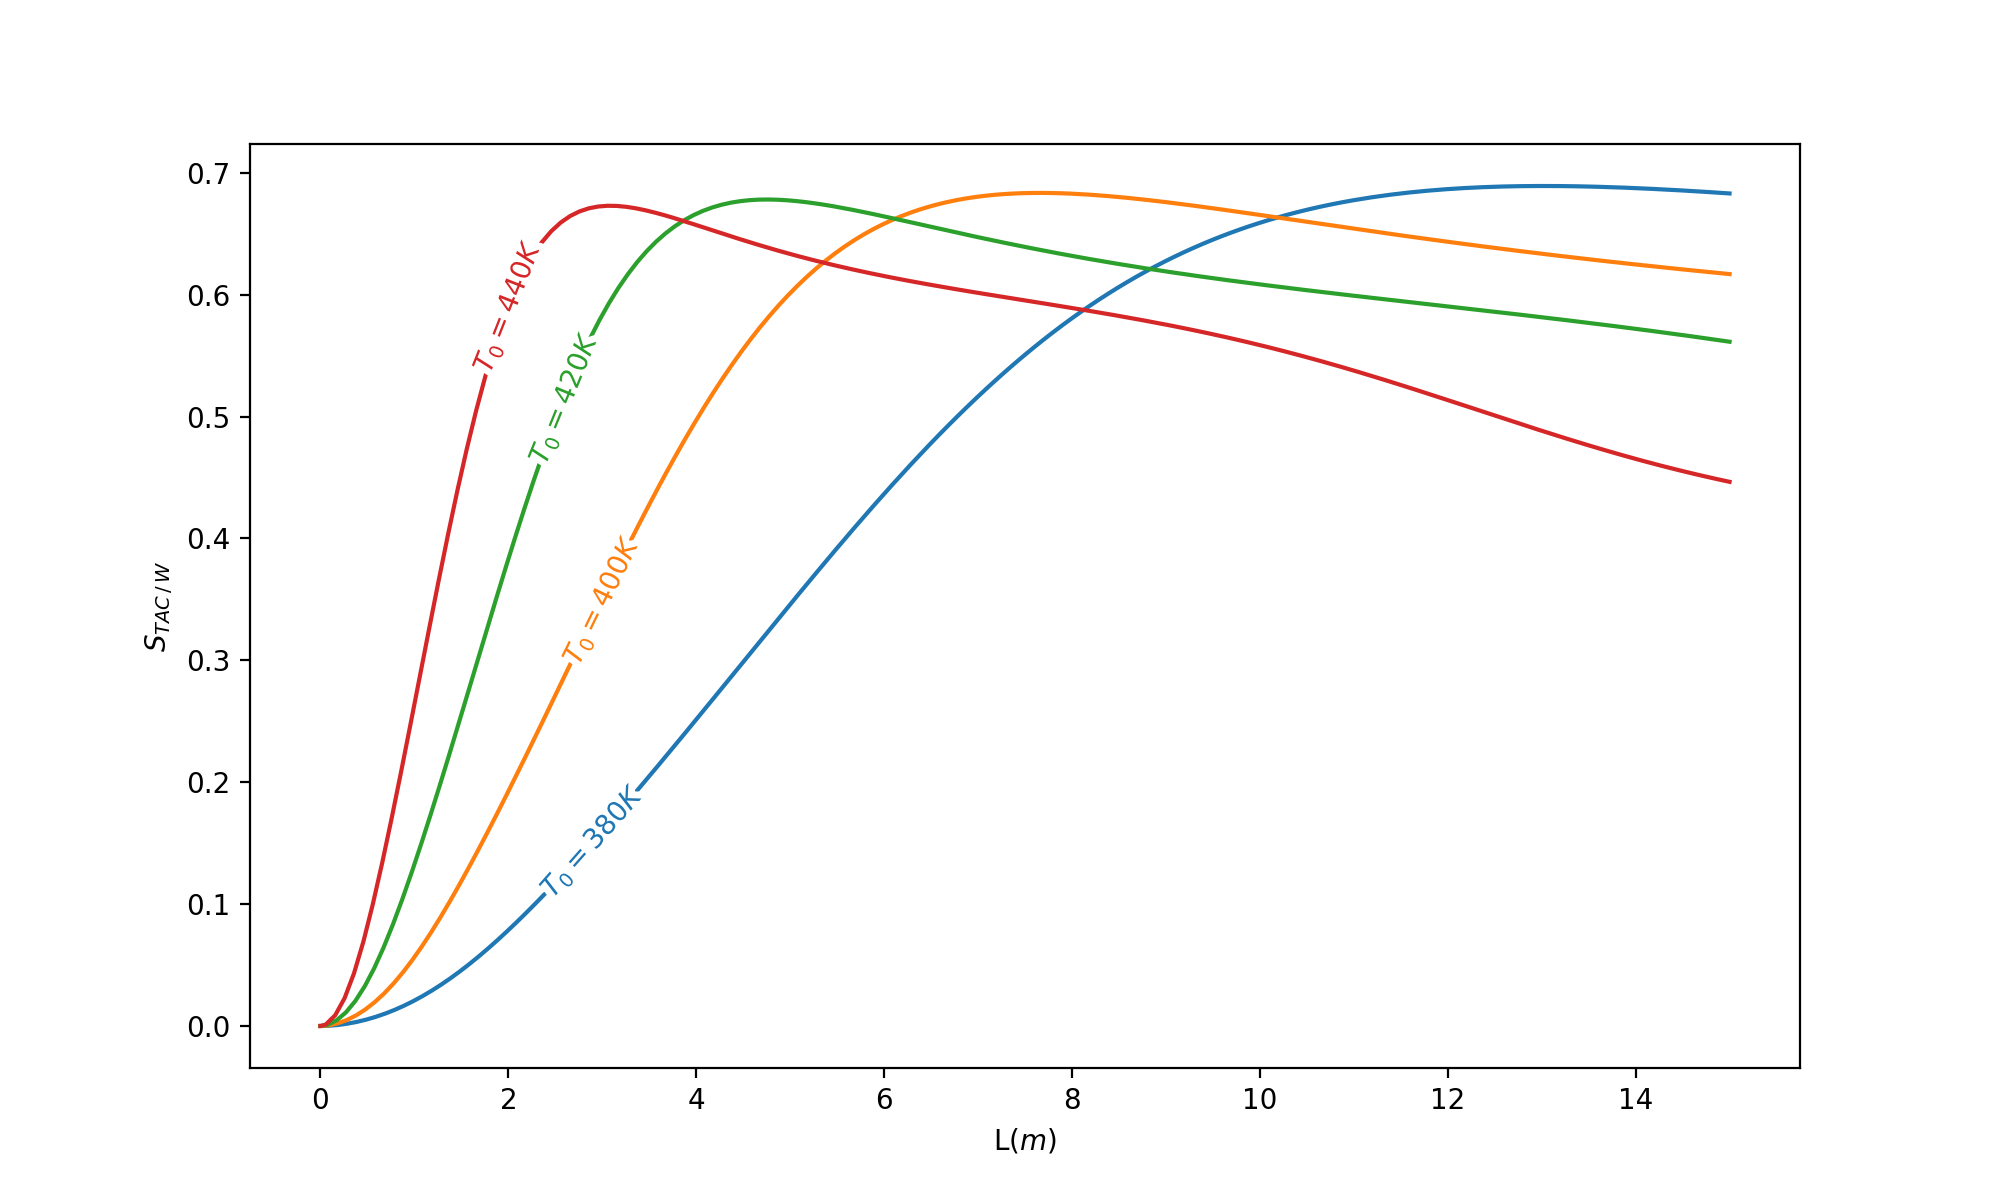

[Text(2.9, 0.15126191228812455, '$T_0=380K$'),
 Text(3.0, 0.34910183715231097, '$T_0=400K$'),
 Text(2.6, 0.5148237607415321, '$T_0=420K$'),
 Text(2.0, 0.5901152610987382, '$T_0=440K$')]

In [22]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

s_tac_W_380 = r380["TAC"] / r380["W"]
s_tac_W_400 = r400["TAC"] / r400["W"]
s_tac_W_420 = r420["TAC"] / r420["W"]
s_tac_W_440 = r440["TAC"] / r440["W"]

ax.set_ylabel("$S_{TAC\,/\,W}$")
ax.set_xlabel("L$(m)$")
s_tac_W_380.plot(ax=ax, legend=False, label="$T_0=380K$")
s_tac_W_400.plot(ax=ax, legend=False, label="$T_0=400K$")
s_tac_W_420.plot(ax=ax, legend=False, label="$T_0=420K$")
s_tac_W_440.plot(ax=ax, legend=False, label="$T_0=440K$")
labelLines(ax.get_lines(), xvals=[2.9, 3.0, 2.6, 2.0], yoffsets=[0, -0.002, -0.002, 0])

In [23]:
def _tac_gly_yield(df):
    return df.iloc[-1]["TAC"] / (df.iloc[0]["GLY"] - df.iloc[-1]["GLY"])

yT = DataFrame(
    [[_tac_gly_yield(F380[F380.index < 10]), 
      _tac_gly_yield(F400[F400.index < 10]), 
      _tac_gly_yield(F420[F420.index < 10]), 
      _tac_gly_yield(F440[F440.index < 10])]], 
    index=["Y TAC/GLY"], 
    columns=[
        "To = 380", 
        "To = 400", 
        "To = 420", 
        "To = 440"]
)

yT

,To = 380,To = 400,To = 420,To = 440
Y TAC/GLY,0.293533,0.400135,0.443306,0.43957


In [24]:
F161, T161, P161, r161 = solve(
    F0=[0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=5, # W / m2 C
    L=15, # m
    max_step=1
)

In [25]:
F81, T81, P81, r81 = solve(
    F0=[0.1, 0.8, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=5, # W / m2 C
    L=15, # m
    max_step=1
)

In [26]:
F41, T41, P41, r41 = solve(
    F0=[0.1, 0.4, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=5, # W / m2 C
    L=15, # m
    max_step=1
)

In [27]:
F321, T321, P321, r321 = solve(
    F0=[0.1, 3.2, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=5, # W / m2 C
    L=15, # m
    max_step=1
)

In [28]:
F641, T641, P641, r641 = solve(
    F0=[0.1, 6.4, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=5, # W / m2 C
    L=15, # m
    max_step=1
)

<IPython.core.display.Javascript object>


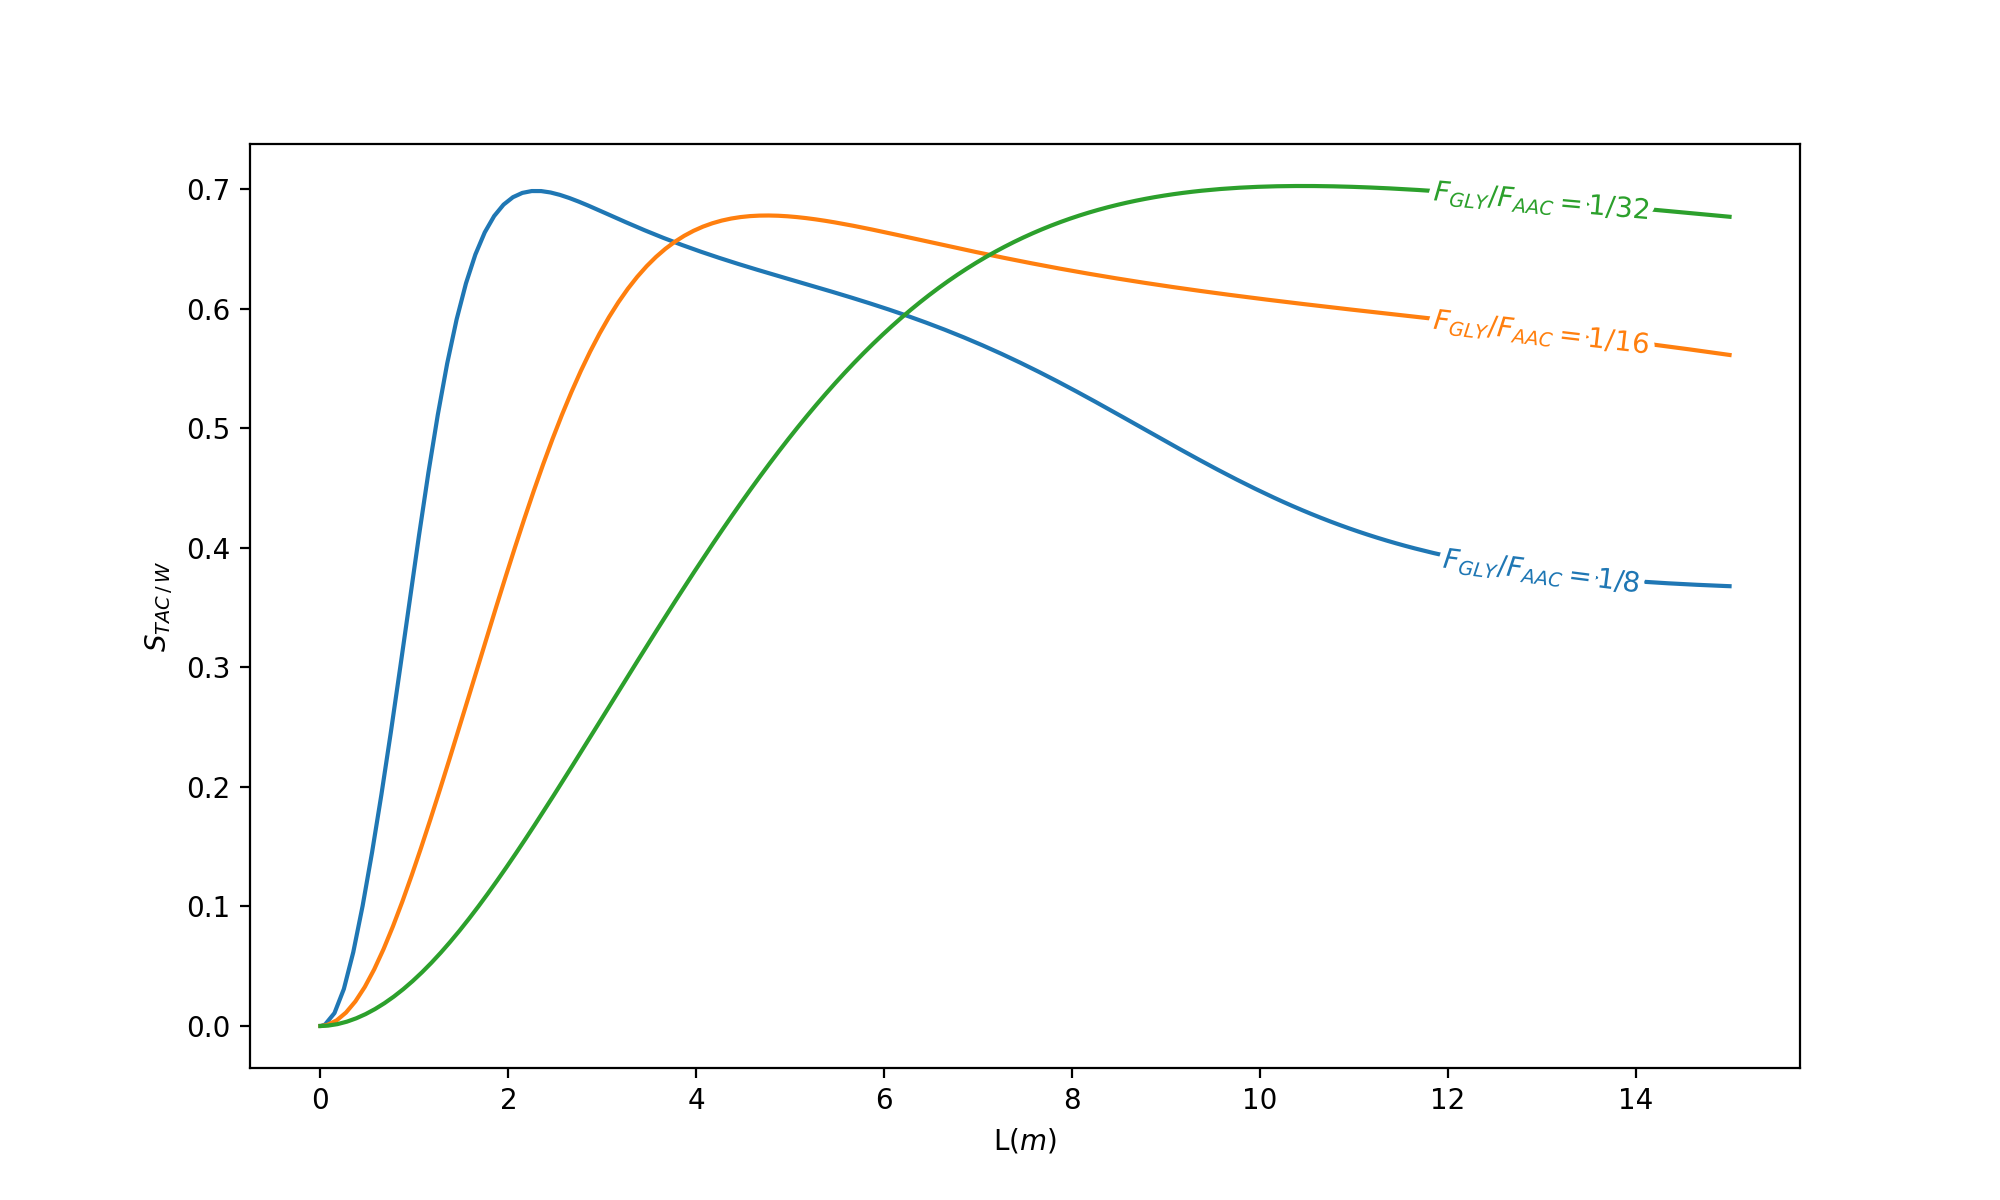

[Text(13.0, 0.37966449602869257, '$F_{GLY}/F_{AAC} = 1/8$'),
 Text(13.0, 0.5794717621538324, '$F_{GLY}/F_{AAC} = 1/16$'),
 Text(13.0, 0.689440443942524, '$F_{GLY}/F_{AAC} = 1/32$')]

In [29]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

s_tac_W_41 = r41["TAC"] / r41["W"]
s_tac_W_81 = r81["TAC"] / r81["W"]
s_tac_W_161 = r161["TAC"] / r161["W"]
s_tac_W_321 = r321["TAC"] / r321["W"]
s_tac_W_641 = r641["TAC"] / r641["W"]

ax.set_ylabel("$S_{TAC\,/\,W}$")
ax.set_xlabel("L$(m)$")
# s_tac_W_41.plot(ax=ax, legend=False, label="$F_{GLY}/F_{AAC} = 1/4$")
s_tac_W_81.plot(ax=ax, legend=False, label="$F_{GLY}/F_{AAC} = 1/8$")
s_tac_W_161.plot(ax=ax, legend=False, label="$F_{GLY}/F_{AAC} = 1/16$")
s_tac_W_321.plot(ax=ax, legend=False, label="$F_{GLY}/F_{AAC} = 1/32$")
# s_tac_W_641.plot(ax=ax, legend=False, label="$F_{GLY}/F_{AAC} = 1/64$")
labelLines(ax.get_lines(), xvals=[13, 13, 13], yoffsets=[0, -0.002, -0.002])

In [30]:
yR = DataFrame(
    [[# _tac_gly_yield(F41[F41.index < 10]), 
      _tac_gly_yield(F81[F81.index < 10]), 
      _tac_gly_yield(F161[F161.index < 10]),
      _tac_gly_yield(F321[F321.index < 10]),
      # _tac_gly_yield(F641[F641.index < 10])]],
    ]],
    index=["Y TAC/GLY"], 
    columns=[ 
        # "F_{GLY}/F_{AAC} = 1/4", 
        "F_{GLY}/F_{AAC} = 1/8", 
        "F_{GLY}/F_{AAC} = 1/16",
        "F_{GLY}/F_{AAC} = 1/32",
        # "F_{GLY}/F_{AAC} = 1/64"]
    ]
)

yR

,F_{GLY}/F_{AAC} = 1/8,F_{GLY}/F_{AAC} = 1/16,F_{GLY}/F_{AAC} = 1/32
Y TAC/GLY,0.3448,0.443306,0.432624


In [31]:
F, T, P, r = solve(
    F0=[0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=5, # W / m2 C
    L=15, # m
    max_step=1
)

<IPython.core.display.Javascript object>


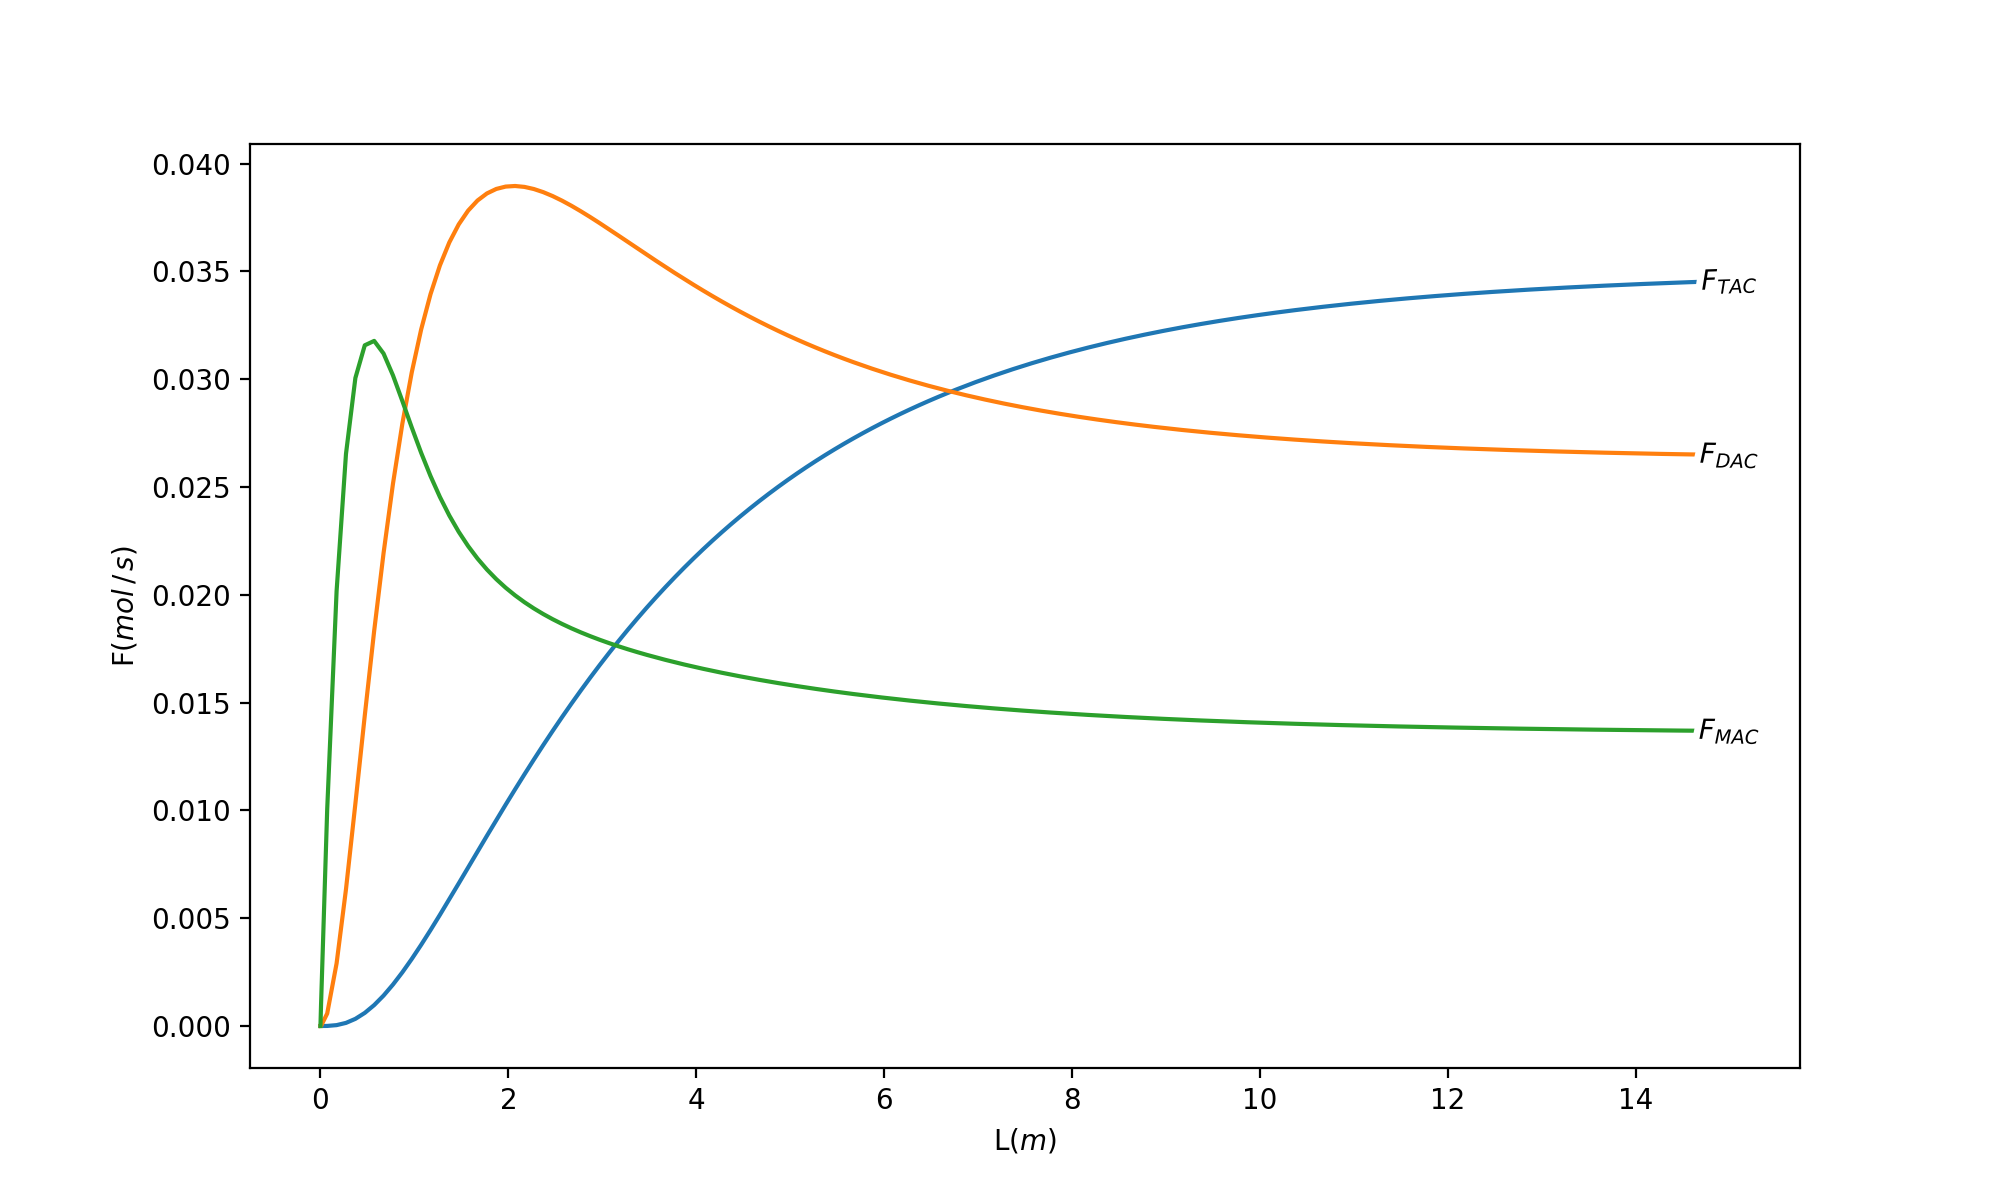

[Text(15.0, 0.034562809455634856, '$F_{TAC}$'),
 Text(15.0, 0.026479301307966815, '$F_{DAC}$'),
 Text(15.0, 0.013681642145030707, '$F_{MAC}$')]

In [32]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

F_of_interest = F[["TAC", "DAC", "MAC"]]


ax.set_ylabel("F$(mol\,/\,s)$")
ax.set_xlabel("L$(m)$")

for column in F_of_interest.columns:
    F_of_interest[column].plot(ax=ax, legend=False, label=f"$F_{{{column}}}$", style="-")     

labelLines(ax.get_lines(), xvals=[15, 15, 15, ], color="k")

<IPython.core.display.Javascript object>


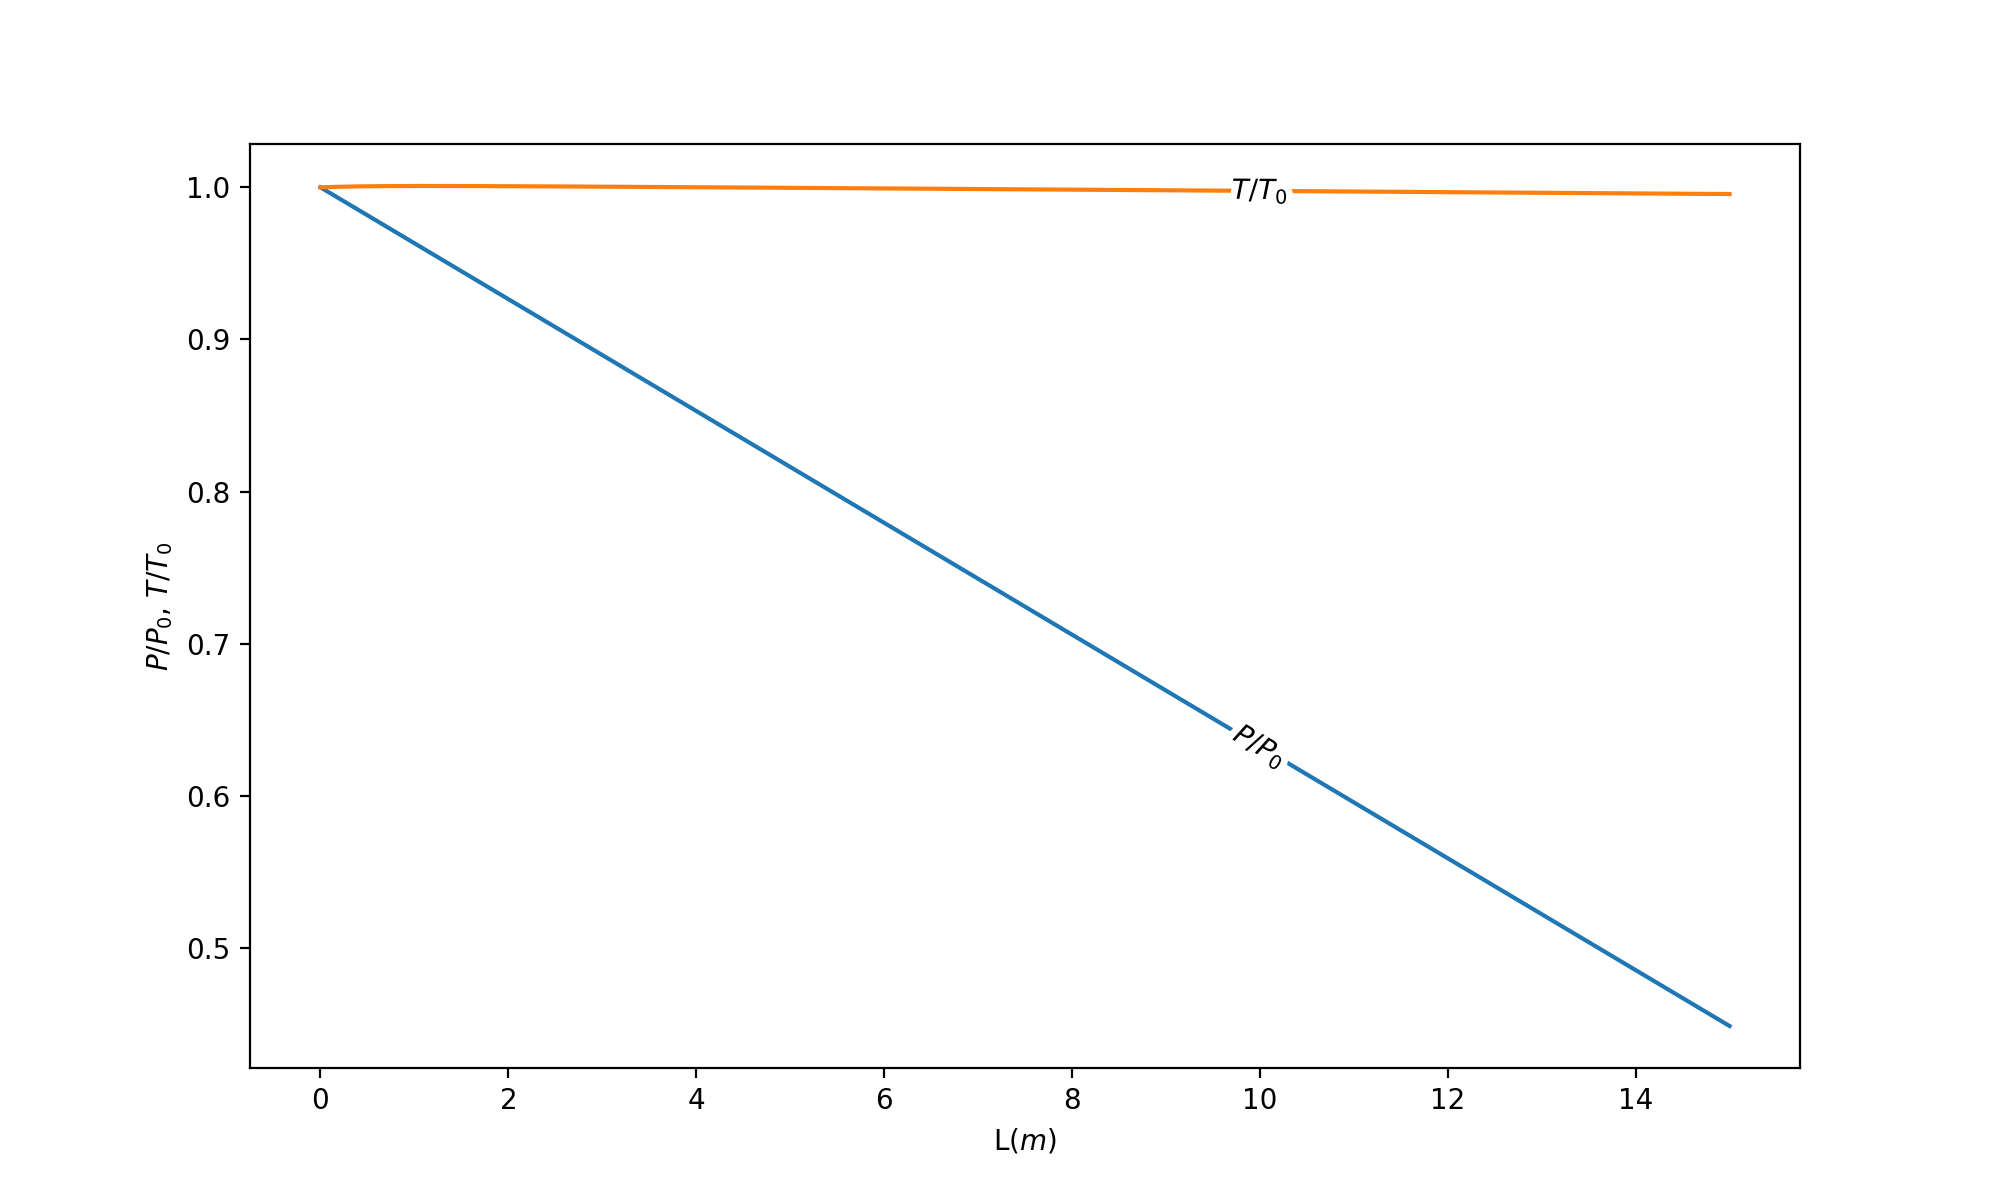

[Text(10.0, 0.632589698218011, '$P / P_0$'),
 Text(10.0, 0.9976545669576885, '$T / T_0$')]

In [33]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.set_ylabel("$P / P_0$, $T / T_0$")
ax.set_xlabel("L$(m)$")

Pnorm = P / P.iloc[0]
Tnorm = T / T.iloc[0]

Pnorm.plot(ax=ax, legend=False, label="$P / P_0$")
Tnorm.plot(ax=ax, legend=False, label="$T / T_0$")

labelLines(ax.get_lines(), xvals=[10, 10], color="k")

In [34]:
pressure_drop = P.iloc[0] - P.iloc[-1]
pressure_drop

1.65334635801895

In [35]:
temperature_drop = T.iloc[0] - T.iloc[-1]
temperature_drop

1.8551970489704104

In [44]:
yearly_production = 10000 * 1000 # kg / y
production = yearly_production * (1 / 365)  * (1 / 24) * (1 / 3600)
production = production * 1000 / substance_data["MW(g/mol)"]["TAC"]
production

1.4532183881115135

In [48]:
production_g = F[F.index <= 10].iloc[-1]["TAC"] * substance_data["MW(g/mol)"]["TAC"]
production_g

7.193642174476582

In [49]:
n_tubes = production / F[F.index <= 10].iloc[-1]["TAC"]
n_tubes

44.080302042646196

In [39]:
substance_data

,Cp(J/molK),Hf(J/mol),MW(g/mol),p(kg/m3)
Species,,,,
GLY,221.18,-669600.0,92.0938,1260.00
AAC,159.80,-483520.0,60.0520,1050.00
W,75.38,-285830.0,18.0153,997.77
TAC,389.00,-1330800.0,218.2039,1160.00
DAC,340.98,-1120700.0,176.1672,1170.00
MAC,291.36,-903530.0,134.1305,1200.00


In [40]:
_estimate_volumetric_flow([0.1, 1.6, 0, 0, 0, 0])

0.09881684126984128

In [41]:
np.sum(F420.iloc[-1])

1.7000000000000013

In [42]:
F420.iloc[-1]

GLY    0.025276
AAC    1.429671
W      0.170329
TAC    0.034563
DAC    0.026479
MAC    0.013682
Name: 15.0, dtype: float64

In [43]:
F380.shape[0]

153

In [50]:
F

,GLY,AAC,W,TAC,DAC,MAC
0.000000,0.100000,1.600000,0.000000,0.000000e+00,0.000000,0.000000
0.006529,0.098976,1.598971,0.001029,2.623310e-09,0.000005,0.001019
0.071820,0.089364,1.588780,0.011220,3.274901e-06,0.000578,0.010054
0.171820,0.076883,1.573897,0.026103,4.049224e-05,0.002905,0.020171
0.271820,0.066976,1.560344,0.039656,1.442683e-04,0.006344,0.026536
...,...,...,...,...,...,...
14.671820,0.025289,1.429757,0.170243,3.451461e-02,0.026503,0.013694
14.771820,0.025285,1.429730,0.170270,3.452975e-02,0.026495,0.013690
14.871820,0.025281,1.429704,0.170296,3.454449e-02,0.026488,0.013686
14.971820,0.025277,1.429678,0.170322,3.455884e-02,0.026481,0.013683


In [56]:
F[F.index > 9][F[F.index > 9].index <= 11]

,GLY,AAC,W,TAC,DAC,MAC
9.07182,0.025759,1.433421,0.166579,0.032323,0.027692,0.014227
9.17182,0.025743,1.433290,0.166710,0.032404,0.027645,0.014208
9.27182,0.025728,1.433163,0.166837,0.032482,0.027600,0.014189
9.37182,0.025714,1.433039,0.166961,0.032558,0.027557,0.014171
9.47182,0.025699,1.432920,0.167080,0.032632,0.027515,0.014153
9.57182,0.025685,1.432803,0.167197,0.032703,0.027475,0.014136
9.67182,0.025672,1.432690,0.167310,0.032773,0.027436,0.014120
9.77182,0.025658,1.432581,0.167419,0.032840,0.027398,0.014104
9.87182,0.025645,1.432474,0.167526,0.032905,0.027362,0.014088
9.97182,0.025633,1.432371,0.167629,0.032968,0.027327,0.014073
